# Question 7

In [1]:
import torchvision
import torch
import torchvision.transforms as transforms

root = "../data"
batch_size = 16

transform = transforms.Compose(
    [transforms.ToTensor()])


train = torchvision.datasets.MNIST(root=root, train=True, download=True, transform=transform)

test = torchvision.datasets.MNIST(root=root, train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=True, num_workers=2)

In [2]:
train.data.shape, train.targets.shape

(torch.Size([60000, 28, 28]), torch.Size([60000]))

In [3]:
image, label = train[0]

##### Split training data into 50k training instances and 10k validation instances.

In [4]:
from torch.utils.data import random_split

generator = torch.Generator().manual_seed(42)

train_size = 50000
val_size = 10000

train_dataset, val_dataset = random_split(
    train, 
    [train_size, val_size], 
    generator=generator
)

##### Training loop (we will finish it on question 8)

In [5]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

epochs = 5
for epoch in range(epochs):
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        pass
    

# Question 8

In [6]:
import torch.nn as nn
import torch.nn.functional as F

### Building the model

In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1, stride=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1, stride=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1, stride=1)
        self.fc1 = nn.Linear(64 * 3 * 3, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.fc1(x)
        return x
    
net = Net()

In [8]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(), lr=0.0003)

### Finished Training Loop

In [9]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

epochs = 2
for epoch in range(epochs):
    running_loss = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')
    

[1,  2000] loss: 0.358
[2,  2000] loss: 0.086
Finished Training


In [10]:
len(train_dataset)

50000

### Saving the model

In [11]:
#PATH = './mnist_net.pth'
#torch.save(net.state_dict(), PATH)

### Validation Accuracy

In [12]:
correct = 0
total = 0

val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

with torch.no_grad():
    for data in val_loader:
        images, labels = data
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 validation images: {100 * correct // total} %')

Accuracy of the network on the 10000 validation images: 97 %


In [13]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 98 %


# Question 9

### Applying transformations to the training data.

In [75]:
train_dataset.dataset.data.float().std()

tensor(78.5675)

In [110]:
import torchvision.transforms.v2 as transforms

mnist_mean = train_dataset.dataset.data.float().mean().item()
mnist_std = train_dataset.dataset.data.float().std().item()

transform_aug = transforms.Compose([
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomCrop(size=(28, 28), padding=2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0], std=[0.2]),
])

transform_base = transforms.Compose(
    [transforms.ToTensor()])

base_train = torchvision.datasets.MNIST(root=root, train=True, download=True, transform=transform_base)

augmented_train = torchvision.datasets.MNIST(root=root, train=True, download=True, transform=transform_aug)

 

### Rerun the training loop with base (Now with the complete training set)

In [94]:
base_train_loader = torch.utils.data.DataLoader(base_train, batch_size=batch_size, shuffle=True, num_workers=2)

# Initialize the model
net = Net()

# Initialize criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(), lr=0.0003)

epochs = 2
for epoch in range(epochs):
    running_loss = 0
    for i, data in enumerate(base_train_loader, 0):
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')
    

[1,  2000] loss: 0.353
[2,  2000] loss: 0.079
Finished Training


### Test the baseline data

In [95]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 98 %


### Run training loop with augmented data

In [111]:
augmented_train_loader = torch.utils.data.DataLoader(augmented_train, batch_size=batch_size, shuffle=True, num_workers=2)

# Initialize the model
net = Net()

# Initialize criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(), lr=0.0003)

epochs = 2
for epoch in range(epochs):
    running_loss = 0
    for i, data in enumerate(augmented_train_loader, 0):
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')
    

[1,  2000] loss: 0.382
[2,  2000] loss: 0.096
Finished Training


### Test the augmented data

In [112]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 98 %


### Why do we only augment the training data?

It is considered best practice to avoid applying data augmentation to the validation and test sets, as this can compromise the reliability of model evaluation. The purpose of augmentation is to artificially increase the diversity of the training data in order to improve the model’s ability to generalize. However, augmenting the validation or test data can significantly distort evaluation metrics. 
For example, flipping an image of the digit 9 in the test set might transform it into something that resembles a 6. If the model then predicts 6, this would be recorded as an incorrect classification, even though the prediction would be reasonable given the augmented input. Such transformations introduce inconsistencies that make the evaluation no longer reflect performance on the true underlying data distribution. Therefore, augmenting validation or test data can harm the evaluation process, and augmentation should only be applied to the training set.

# Question 12

### Let's load the ImageFolder data.

In [166]:
import torchvision
import torch
import torchvision.transforms.v2 as transforms 

root = "../data/mnist-varres"
batch_size = 16

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28,28)),
    transforms.ToTensor()
    ])


train = torchvision.datasets.ImageFolder(root=root + "/train", transform=transform)
trainloader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=2)

test = torchvision.datasets.ImageFolder(root=root + "/test", transform=transform)
testloader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=True, num_workers=2)

In [167]:
img, label = train[0]

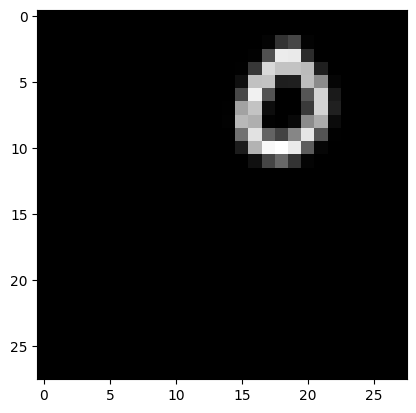

In [168]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')
    plt.show()

imshow(img)

### Training the model

In [158]:

# Initialize the model
net = Net()

# Initialize criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(), lr=0.0003)

epochs = 2
for epoch in range(epochs):
    running_loss = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0

print('Finished Training')
    

[1,   200] loss: 0.070
[1,   400] loss: 0.035
[1,   600] loss: 0.019
[2,   200] loss: 0.012
[2,   400] loss: 0.008
[2,   600] loss: 0.007
Finished Training


### Now, we test the model

##### As expected, reducing the image size had a strong negative impact on accuracy. This helped us verify that when the images are downsampled, a significant amount of visual information is lost. 
##### Since the classifier received less detailed representations of each image, its ability to correctly identify digits decreased, leading to a lower performance.

In [159]:
correct = 0
total = 0

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 20 %


# Question 13

As shown in the 64×64 version of an image from the MNIST dataset (Figure \ref{fig:ex13_zero_64}), resizing the images to 64×64 simply adds extra black pixels that contain no useful information. This additional padding may cause the model to focus on irrelevant regions of the image, which can negatively impact its performance.